In [532]:
# from theano.sandbox import cuda
# cuda.use('gpu0')
import os, sys
current_dir = os.getcwd()
from keras.layers import Merge
import time
# import imageio
from keras.models import model_from_json
import bcolz
import pdb
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
from keras import backend as K
K.set_session(sess)
import pandas as pd
from keras.callbacks import LearningRateScheduler

In [533]:
import utils; reload(utils)
import model_util; reload(model_util)
from model_util import *
from utils import *
from IPython.display import FileLink
%matplotlib inline
from random import shuffle
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rc('font', family='serif')

In [534]:
seed = 7
np.random.seed(seed)

In [535]:
vi = visualization()

In [536]:
dh = data_handler()
laser, rgb, depth, ret = dh.load(data_path = 'data/sensor/')

laser_shuffle = []
rgb_shuffle = []
depth_shuffle = []
index_shuf = range(laser.shape[0])
shuffle(index_shuf)
for i in index_shuf:
    laser_shuffle.append(laser[i])
    rgb_shuffle.append(rgb[i])
    depth_shuffle.append(depth[i])

In [537]:
laser = np.array(laser_shuffle)
rgb = np.array(rgb_shuffle)
depth = np.array(depth_shuffle)

# km = keras_model(output_shape = laser.shape[1])

print 'Laser: ' + str(laser.shape)
print 'Depth: ' + str(depth.shape)
print 'RGB: ' + str(rgb.shape)
N = laser.shape[0]
rgb_train = rgb

batch_size = 64
no_of_epochs = 1

Laser: (4756, 121)
Depth: (4756, 40, 640, 1)
RGB: (4756, 40, 640, 3)


In [538]:
N_val = 100
laser_val = laser[-N_val:,:]
rgb_val = rgb[-N_val:,:,:,:]
depth_val = depth[-N_val:,:,:,:]
print laser_val.shape
print rgb_val.shape
print depth_val.shape

(100, 121)
(100, 40, 640, 3)
(100, 40, 640, 1)


In [539]:
# km.final_model.fit([depth, rgb], laser, validation_split = 0.2,nb_epoch=no_of_epochs, batch_size=batch_size,callbacks=[km.tbCallback, km.lrate])

In [540]:
def mean_squared_error_exp(y_true, y_pred):
#     diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),K.epsilon(),None))
    return K.mean(K.square(y_pred - y_true), axis=-1) + K.mean(K.square(tf.maximum(0.,y_pred-y_true)),axis=-1) + K.mean(K.square(tf.maximum(0.,-(y_pred+0.5))),axis=-1)
#+ K.mean(tf.log(1.+tf.exp(y_pred-(y_true+0.3))) ,axis=-1)
#+10.*K.mean(tf.log(1.+tf.exp(10.*(-y_pred+0.3))),axis=-1)+K.mean(tf.log(1+tf.exp(y_pred-(y_true+0.3))) ,axis=-1)
#+100. * K.mean(diff, axis=-1)
# (1e-6/(1+tf.exp(y_pred*100-0.3)

In [541]:
def conv1():
    rgb_model = Sequential([
            BatchNormalization(axis=1, input_shape=(40,640,3)),
            Convolution2D(8,3,3, activation='relu',dim_ordering = 'tf'),
            MaxPooling2D((2,2)),
            BatchNormalization(axis=1),
            Convolution2D(8,3,3, activation='relu',dim_ordering = 'tf'),
            MaxPooling2D((2,2)),
            BatchNormalization(axis=1),
            Convolution2D(32,3,3, activation='relu',dim_ordering = 'tf'),
#             Convolution2D(32,1,3, activation='relu',dim_ordering = 'tf'),
            MaxPooling2D((4,4)),
            BatchNormalization(axis=1),
#             MaxPooling2D((1,3)),
#             Convolution2D(64,1,11, activation='relu',dim_ordering = 'tf'),
#             MaxPooling2D((2,3)),
            Flatten()
#             Dense(200, activation='relu'),
#             BatchNormalization(),
#             Dense(233, activation='linear')
        ])
    depth_model = Sequential([
            BatchNormalization(axis=1, input_shape=(40,640,1)),
            Convolution2D(8,3,3, activation='linear',border_mode='same',dim_ordering = 'tf'),
            AveragePooling2D((3,3)),
            BatchNormalization(axis=1),
            Convolution2D(8,3,3, activation='relu',border_mode='same',dim_ordering = 'tf'),
            Convolution2D(16,3,3, activation='relu',border_mode='same',dim_ordering = 'tf'),
            AveragePooling2D((2,2)),
            BatchNormalization(axis=1),
            Convolution2D(16,3,3, activation='relu',dim_ordering = 'tf'),
            AveragePooling2D((3,3)),
            BatchNormalization(axis=1),
            Convolution2D(128,1,3, activation='relu',border_mode='same',dim_ordering = 'tf'),
            AveragePooling2D((1,3)),
            BatchNormalization(axis=1),
            Flatten()
#             Dense(640, activation='relu')
#             Dense(512, activation='relu')
#             Dense(640, activation='relu')
#             BatchNormalization()
#             Dense(233, activation='linear')
        ]) 
    final_model = Sequential()
    final_model.add(Merge([rgb_model, depth_model],mode='concat'))
    final_model.add(Dropout(0.5))
    final_model.add(BatchNormalization())
    final_model.add(Dense(512, activation='relu',init='lecun_uniform'))
    final_model.add(Dropout(0.5))
    final_model.add(BatchNormalization())
    final_model.add(Dense(121, activation='linear', init='lecun_uniform'))
    

#     model.fit_generator([rgb, laser],laser.shape[0], nb_epoch=no_of_epochs)
#     model.optimizer.lr = 0.001
#     model.fit_generator(depth, laser, validation_split = 0.2,nb_epoch=no_of_epochs, batch_size=batch_size)
    return final_model

model = conv1()

In [542]:
def mean_squared_error_exp(y_true, y_pred):
#     diff = K.abs((y_true - y_pred) / K.clip(K.abs(y_true),K.epsilon(),None))
    return K.mean(K.square(y_pred - y_true), axis=-1) + K.mean(K.square(tf.maximum(0.,y_pred-y_true)),axis=-1) + K.mean(K.square(tf.maximum(0.,-(y_pred+0.5))),axis=-1)
#+ K.mean(tf.log(1.+tf.exp(y_pred-(y_true+0.3))) ,axis=-1)
#+10.*K.mean(tf.log(1.+tf.exp(10.*(-y_pred+0.3))),axis=-1)+K.mean(tf.log(1+tf.exp(y_pred-(y_true+0.3))) ,axis=-1)
#+100. * K.mean(diff, axis=-1)
# (1e-6/(1+tf.exp(y_pred*100-0.3)

In [543]:
sgd = SGD(lr=0.0, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(optimizer = sgd, loss='mse')
# mean_squared_error_exp

In [546]:
# model.summary()
model.save_weights('models/random_init.h5')

In [547]:
#model.load_weights('models/model_notebook.h5')

In [551]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [552]:


# model.optimizer.lr=0.1
# tbCallback=keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

In [555]:
def train_multiple(dp_model,N,val_data, num_epoch):
    laser_s = laser[:N,:]
    rgb_s = rgb[:N,:,:,:]
    depth_s = depth[:N,:,:]
    batch_size = 64
    no_of_epochs = 50
    # validation_split = 0.2
    return dp_model.fit([rgb_s,depth_s], laser_s, nb_epoch=num_epoch, validation_data = val_data, batch_size=batch_size,callbacks=[lrate])

In [668]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_12 (BatchNorm (None, 40, 640, 3)    160                                          
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 38, 638, 8)    224                                          
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 19, 319, 8)    0                                            
____________________________________________________________________________________________________
batchnormalization_13 (BatchNorm (None, 19, 319, 8)    76                                           
___________________________________________________________________________________________

In [637]:
from keras.callbacks import History 
N_epoch = 100
hist_train = []
image_range = range(100, 1100,100)
for N in image_range:
    model.reset_states()
    model.load_weights('models/random_init.h5')
    hist_train.append(train_multiple(model,N,([rgb_val,depth_val],laser_val),N_epoch))
    
# N = 300
# result = model.predict([depth[N:N+1,:,:,:]])
# result = model.predict([rgb[N:N+1,:,:,:], depth[N:N+1,:,:,:]])
# pose = [0.,0.,0.]
# vi.depth_plot(np.mean(depth[N,15:35,:,:],axis=0),pose)
# vi.laser_plot2(np.mean(depth[N,15:35,:,:],axis=0),640,'g')
# vi.laser_plot2(laser[N,:],100,'b')
# vi.laser_plot2(result[0],100,'r')
# plt.plot(0,0,'or')

Train on 100 samples, validate on 100 samples
Epoch 1/100
100/100 [==============================] - 2s - loss: 9.6192 - val_loss: 6.6849
Epoch 2/100
100/100 [==============================] - 2s - loss: 8.9937 - val_loss: 5.7926
Epoch 3/100
100/100 [==============================] - 2s - loss: 7.9955 - val_loss: 2.8947
Epoch 4/100
100/100 [==============================] - 2s - loss: 7.0958 - val_loss: 4.7788
Epoch 5/100
100/100 [==============================] - 2s - loss: 6.2210 - val_loss: 34.4169
Epoch 6/100
100/100 [==============================] - 2s - loss: 5.6197 - val_loss: 88.0501
Epoch 7/100
100/100 [==============================] - 2s - loss: 4.9992 - val_loss: 114.9848
Epoch 8/100
100/100 [==============================] - 2s - loss: 4.3947 - val_loss: 70.2985
Epoch 9/100
100/100 [==============================] - 2s - loss: 3.6863 - val_loss: 19.5799
Epoch 10/100
100/100 [==============================] - 2s - loss: 3.0989 - val_loss: 23.8700
Epoch 11/100
100/100 [====

In [595]:
print hist_train[0].history.get('loss')

[9.6625012969970712, 8.7018535995483397, 7.1336723709106442, 6.0279521369934086, 5.036773681640625, 4.0533771133422851, 3.0434076595306396, 2.047773952484131, 1.598830327987671, 1.3452513456344604, 1.441579647064209, 1.67425696849823, 1.7712287187576294, 1.5212689113616944, 1.5851267194747924, 1.0704784297943115, 1.0025968909263612, 1.0094280815124512, 0.9597346496582031, 0.82326582908630375, 0.92791696071624752, 0.9083153629302978, 0.87917443037033083, 0.7955659365653992, 0.85988250494003293, 0.77930734634399412, 0.77671305656433109, 0.81762125968933108, 0.78191355228424075, 0.74100848436355593]


In [636]:
history_np = np.array(hist_train)
np.save('loss_2000',history_np)

PicklingError: Can't pickle <type 'module'>: attribute lookup __builtin__.module failed

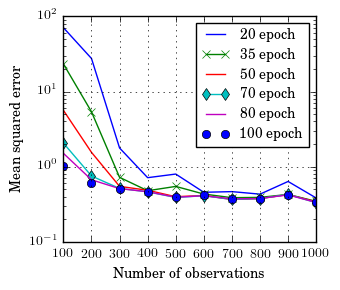

In [667]:
loss_array = []
val_array = []
for i in range(len(hist_train)):
    loss_data = hist_train[i].history.get('loss')
    val_loss_data = hist_train[i].history.get('val_loss')
    loss_array.append([loss_data[-75],loss_data[-65],loss_data[-50],loss_data[-30],loss_data[-20],loss_data[-1]])
    val_array.append([val_loss_data[-77],val_loss_data[-65],val_loss_data[-50],val_loss_data[-30],val_loss_data[-20],val_loss_data[-1]])
    
    
lossnp = np.array(loss_array)
val_lossnp = np.array(val_array)


num_x = image_range

fig = plt.figure(figsize=(3.5,3), dpi=80)
plt.semilogy(num_x,val_lossnp[:,-6],label='20 epoch')
plt.semilogy(num_x,val_lossnp[:,-5],'x-',label='35 epoch')
plt.semilogy(num_x,val_lossnp[:,-4],label='50 epoch')
plt.semilogy(num_x,val_lossnp[:,-3],'-d',label='70 epoch')
plt.semilogy(num_x,val_lossnp[:,-2],label='80 epoch')
plt.semilogy(num_x,val_lossnp[:,-1],'bo',label='100 epoch')

plt.ylabel('Mean squared error')
plt.xlabel('Number of observations')
plt.legend(fontsize=10)
plt.grid()
plt.tight_layout()
pp = PdfPages('num_image.pdf')
pp.savefig(fig)
pp.close()
plt.show()

In [217]:
model_json = model.to_json()
with open("models/model_low_p.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
json_file.close()
model.save_weights("models/model_notebook_low_p.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
#  for paper use model_low.json with model_notebook_low.h5
json_file = open('models/model_low.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("models/model_notebook_low.h5")
print("Loaded model from disk")

Loaded model from disk


In [323]:
result.shape

(1, 121)

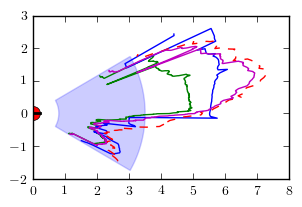

In [411]:
N = 30
result = loaded_model.predict([rgb[N:N+1,:,:,:], depth[N:N+1,:,:,:]])
pose = [0.,0.,0.]

vi.start_fig((3.3,2.1))
# ax = fig.add_subplot(1, 1, 1)
# vi.fov((0.,0.), -30, 30,100,fill=True, color='blue')

vi.laser_plot2(np.mean(depth[N,15:35,:,:],axis=0).T[0],640,'g','RGB-D')
vi.laser_plot2(laser[N,:],laser.shape[1],'b','Ground truth')
vi.laser_plot2(result[0],laser.shape[1],'r--','Prediction')
depth_new = np.mean(depth[N,15:35,:,:],axis=0).T[0]

from scipy.interpolate import interp1d
laser_fov = result[0]
original_span = np.linspace(0,1,laser_fov.shape[0])
f = interp1d(original_span,laser_fov)
reduced_span = np.linspace(0,1,640)
laser_fov = f(reduced_span)

def bayes_update(prior_array, likelihood_array):
    fused_out = []
    for i in range(prior_array.shape[0]):
        prior = prior_array[i]
        likelihood = likelihood_array[i]
        x = np.linspace(0,10,1000)
        mu = prior
        mu2 = likelihood
        sigma = 1./10*(prior)**2
        sigma2 = 1./(1+np.exp(-likelihood-4))
        pz = 1./(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))
        pdz = 1./(2*np.pi*sigma2**2)*np.exp(-(x-mu2)**2/(2*sigma2**2))
        fused_out.append(x[np.argmax(pdz*pz)])
    return fused_out
# post = np.zeros(640)


post = bayes_update(depth_new,laser_fov) 

    
result_new = depth_new*np.exp(-(depth_new)**2/(2*2)**2)+laser_fov*np.exp(-(laser_fov+3)**2/(2*4)**2)
vi.laser_plot2(post,result_new.shape[0],'m','Proposed')
# vi.set_lim([-0.5,10],[-3,3.5],1,False)
# vi.save_fig('007.pdf')

In [381]:
post_np = np.array(post)
post_np.shape

(640,)

In [327]:
def resample_data(data, num):
    original_span = np.linspace(0,1,data.shape[0])
    f = interp1d(original_span,data)
    reduced_span = np.linspace(0,1,num)
    return f(reduced_span)

# new_scan = resample_data(result[0],121)
# new_scan.shape

(480, 640)
(1, 480, 640, 3)


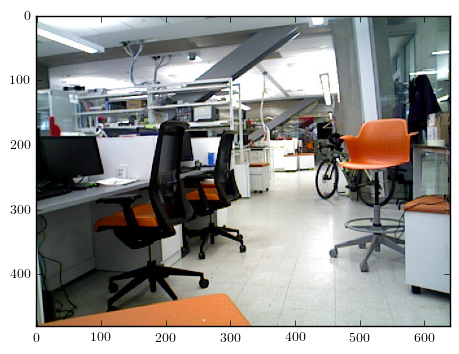

In [941]:
import cv2
from IPython.display import Image


data_path = ''
depth_dir = data_path+'depth/'
rgb_dir = data_path + 'rgb/'

filename = os.listdir(depth_dir)
filename_in = filename[43]
depth_in = np.load(depth_dir+filename_in)*0.001
rgb_in  = cv2.imread(rgb_dir+filename_in[:-3]+'jpg')
rgb_in_p = rgb_in
plt.imshow(rgb_in)

depth_in_f = pd.DataFrame(depth_in)
depth_in_f = depth_in_f.fillna(method='ffill',axis=1)
depth_in_f = depth_in_f.fillna(method='bfill',axis=1)

depth_in2 = depth_in[None,...,None]
rgb_in = rgb_in[None,...]
print depth_in.shape
print rgb_in[0:40,:,:].shape

In [942]:
N = 10

I_p = np.zeros((480-40,121))
for i in range(480-40):
    I_p[i,:] = loaded_model.predict([rgb_in[:,i:i+40,:,:], depth_in2[:,i:i+40,:,:]])

In [943]:
I_p.max()

9.4940004348754883

In [944]:
from scipy import ndimage
from scipy.misc import imresize
I_p_rs = imresize(I_p,(440,640),interp='nearest')
I_p_rs = I_p_rs/256.*I_p.max()
I_p_bi = np.zeros(I_p_rs.shape)
for i in range(440):
        I_p_bi[i,:] = bayes_update(depth_in[i+20,:],I_p_rs[i,:])

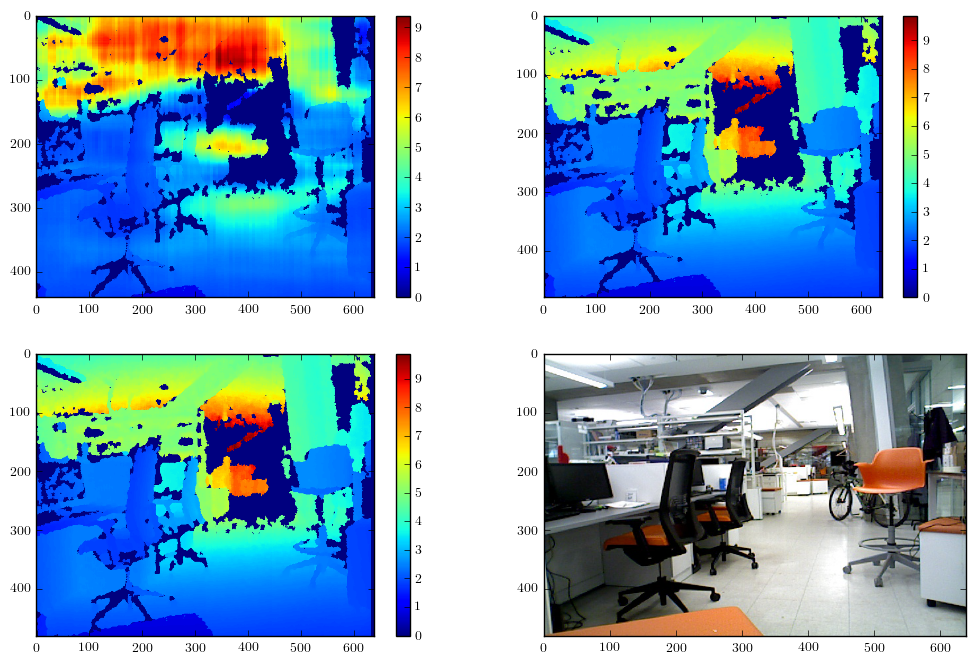

In [946]:
# from matplotlib.colors import BoundaryNorm
# cmap = plt.get_cmap('PiYG')
# norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

f, axarray = plt.subplots(2, 2,figsize=(12,8))
prop = axarray[0,0].imshow(I_p_bi, cmap='jet',aspect='auto' )
f.colorbar(prop,ax=axarray[0,0])
filt = axarray[0,1].imshow(depth_in_f, cmap='jet',aspect='auto' )
f.colorbar(filt,ax=axarray[0,1])
orig = axarray[1,0].imshow(depth_in, cmap='jet',aspect='auto')
f.colorbar(orig,ax=axarray[1,0])
diff = axarray[1,1].imshow(rgb_in_p,aspect='auto')
plt.show()

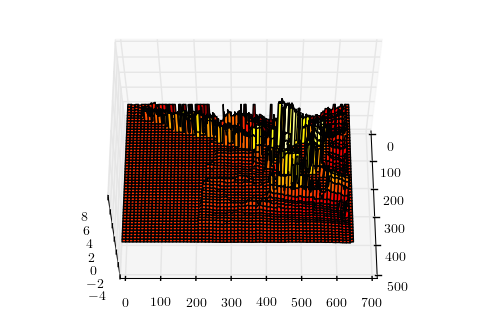

In [827]:
from mpl_toolkits.mplot3d import Axes3D

xx, yy = np.mgrid[0:480, 0:640]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(xx, yy, depth_in-I_p_bi,cmap='hot')
# ax.plot_surface(xx, yy, I_p_bi,cmap='autumn')
ax.view_init(60, 0)
plt.show()

In [413]:
import random
num_sample = 1000
gt = []
rgbd = []
pred = []
predb = []
result = loaded_model.predict([rgb[N:N+1,:,:,:], depth[N:N+1,:,:,:]])
for N in range(num_sample):
    result = loaded_model.predict([rgb[N:N+1,:,:,:], depth[N:N+1,:,:,:]])
    depth_new = np.mean(depth[N,15:35,:,:],axis=0).T[0]
    laser_fov = result[0]
    original_span = np.linspace(0,1,laser_fov.shape[0])
    f = interp1d(original_span,laser_fov)
    reduced_span = np.linspace(0,1,121)
    laser_fov = f(reduced_span)
    laser_rs = resample_data(laser[N,:],121)
    depth_new =  resample_data(depth_new,121)
    gt.append(laser[N,:])
    rgbd.append(depth_new-laser[N,:])
    pred.append(laser_fov-laser[N,:])
    predb.append(bayes_update(depth_new,laser_fov)-laser[N,:])
    

preda = np.array(pred)
preda = preda.flatten()
predba = np.array(predb)
predba = predba.flatten()

gta = np.array(gt)
gta = gta.flatten()

rgbda = np.array(rgbd)
rgbda = rgbda.flatten()

-19.851963316
32.9357126211
std: 0.843599932479
7.77059659206
17.8169638917
std: 1.10347460406
-2.93314506852
13.3077127945
std: 1.08656525804


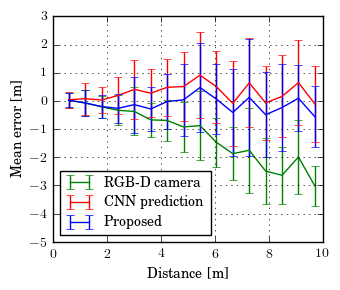

In [970]:
# fig = plt.figure()
# plt.errorbar(gta,gta,yerr=rgbda,ecolor='b')
# plt.errorbar(gta,gta,yerr=preda,ecolor='r')


histogram=plt.figure(figsize=(3.5,3), dpi=80)

# x = [random.gauss(3,1) for _ in range(400)]
# y = [random.gauss(4,2) for _ in range(400)]

nbins = 16

n, _ = np.histogram(gta, bins=nbins)
sy, _ = np.histogram(gta, bins=nbins, weights=rgbda)
sy2, _ = np.histogram(gta, bins=nbins, weights=rgbda*rgbda)
mean = sy / n
print (mean/_[:-1]).mean()*100
print np.abs((mean/_[:-1])).max()*100
std = np.sqrt(sy2/n - mean*mean)
print 'std: '+str(std.mean())
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='g-',label='RGB-D camera')
# bins = np.linspace(0, 10, 100)
# plt.errorbar(gta,rgbd_a, alpha=0.5)

n, _ = np.histogram(gta, bins=nbins)
sy, _ = np.histogram(gta, bins=nbins, weights=preda)
sy2, _ = np.histogram(gta, bins=nbins, weights=preda*preda)
mean = sy / n
print (mean/_[:-1]).mean()*100
print np.abs((mean/_[:-1])).max()*100
std = np.sqrt(sy2/n - mean*mean)
print 'std: '+str(std.mean())
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='r-',label='CNN prediction')

n, _ = np.histogram(gta, bins=nbins)
sy, _ = np.histogram(gta, bins=nbins, weights=predba)
sy2, _ = np.histogram(gta, bins=nbins, weights=predba*predba)
mean = sy / n
dist = _
print (mean/_[:-1]).mean()*100
print np.abs((mean/_[:-1])).max()*100
std = np.sqrt(sy2/n - mean*mean)
print 'std: '+str(std.mean())
plt.errorbar((_[1:] + _[:-1])/2, mean, yerr=std, fmt='b-',label='Proposed')

# from matplotlib.backends.backend_pdf import PdfPages
# plt.hist(y, bins, alpha=0.5)
plt.ylabel('Mean error [m]')
plt.xlabel('Distance [m]')
plt.legend(loc='lower left',fontsize=10)
plt.axis([0, 10, -5, 3])
plt.grid()
plt.tight_layout()
pp = PdfPages('comparison.pdf')
pp.savefig(histogram)
pp.close()
plt.show()



# plot_url = py.plot_mpl(histogram, filename='docs/histogram-mpl-same')

In [285]:
import utils; reload(utils)
import model_util; reload(model_util)
from model_util import *
from utils import *
from IPython.display import FileLink
%matplotlib inline
from random import shuffle
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rc('font', family='serif')
vi = visualization()